# Simple One Hidden Layer Neural Network: Predicting if customers will purchase based on browsing behavior

In [1]:
# Predicting if customers will purchase based on browsing behavior

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader

# Set random seed for reproducibility
torch.manual_seed(42)

In [2]:
# =============================================================================
# Neural Network Module and Training Function
# =============================================================================

class CustomerPurchaseNet(nn.Module):  # Custom neural network class inheriting from nn.Module
    """Neural network to predict customer purchase behavior"""
    
    def __init__(self, input_size, hidden_size, output_size):  # Constructor to define network architecture
        super(CustomerPurchaseNet, self).__init__()  # Call parent constructor
        
        # Define hidden layer: maps input features to hidden neurons
        self.hidden = nn.Linear(input_size, hidden_size)  # Linear transformation: browsing_time -> hidden_features
        
        # Define output layer: maps hidden features to final prediction
        self.output = nn.Linear(hidden_size, output_size)  # Linear transformation: hidden_features -> purchase_probability
    
    def forward(self, x):  # Define forward pass through the network
        # Apply linear transformation followed by ReLU activation to hidden layer
        hidden_output = torch.relu(self.hidden(x))  # ReLU prevents vanishing gradient better than sigmoid
        
        # Apply final linear transformation and sigmoid for probability output
        purchase_probability = torch.sigmoid(self.output(hidden_output))  # Sigmoid maps to [0,1] for probability
        
        return purchase_probability  # Return probability of purchase

In [11]:
def train_model(model, train_loader, criterion, optimizer, num_epochs):  # Training function for the neural network
    """Train the neural network model"""
    loss_history = []  # Track loss over time for plotting
    
    for epoch in range(num_epochs):  # Loop through training epochs
        epoch_loss = 0.0  # Accumulate loss for current epoch
        
        for batch_x, batch_y in train_loader:  # Process data in batches
            optimizer.zero_grad()  # Clear gradients from previous iteration
            
            # Forward pass: compute predictions
            predictions = model(batch_x)  # Get model predictions for current batch
            
            # Compute loss between predictions and true labels
            loss = criterion(predictions, batch_y)  # Binary cross-entropy loss
            
            # Backward pass: compute gradients
            loss.backward()  # Backpropagate error through network
            
            # Update model parameters
            optimizer.step()  # Apply computed gradients to update weights
            
            epoch_loss += loss.item()  # Accumulate loss for monitoring
        
        loss_history.append(epoch_loss / len(train_loader))  # Store average loss per epoch
        
        if (epoch + 1) % 50 == 0:  # Print progress every 50 epochs
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss_history[-1]:.4f}')
    
    return loss_history  # Return loss history for plotting

In [12]:
# =============================================================================
# Make Some Data (Real-world E-commerce Scenario)
# =============================================================================

class CustomerDataset(Dataset):  # Custom dataset class for customer purchase data
    """Dataset containing customer browsing time and purchase decisions"""
    
    def __init__(self, num_samples=1000):  # Generate synthetic but realistic customer data
        # Generate browsing times (in minutes) - most customers browse 1-60 minutes
        from torch.distributions import Exponential
        exponential_dist = Exponential(rate=torch.tensor(0.1))  # Rate parameter for exponential distribution
        self.browsing_time = exponential_dist.sample((num_samples,))  # Sample from exponential distribution
        self.browsing_time = torch.clamp(self.browsing_time, 0.5, 120.0).unsqueeze(1)  # Clamp to realistic range and reshape
        
        # Create realistic purchase behavior: longer browsing time increases purchase probability
        # Add some noise to make it non-linearly separable
        purchase_logits = (self.browsing_time * 0.1 - 2.0).squeeze()  # Base probability from browsing time
        noise = torch.randn(num_samples) * 0.5  # Add random noise to simulate real-world complexity
        purchase_logits += noise  # Make decision boundary non-linear
        
        # Convert logits to binary purchase decisions (0=no purchase, 1=purchase)
        self.purchased = (torch.sigmoid(purchase_logits) > 0.5).float().unsqueeze(1)  # Sigmoid + threshold for binary labels
        
        self.len = num_samples  # Store dataset size
    
    def __getitem__(self, index):  # Required method to get individual samples
        return self.browsing_time[index], self.purchased[index]  # Return (feature, label) pair
    
    def __len__(self):  # Required method to get dataset size
        return self.len  # Return total number of samples



=== Creating Customer Purchase Dataset ===
Dataset created with 800 customer records


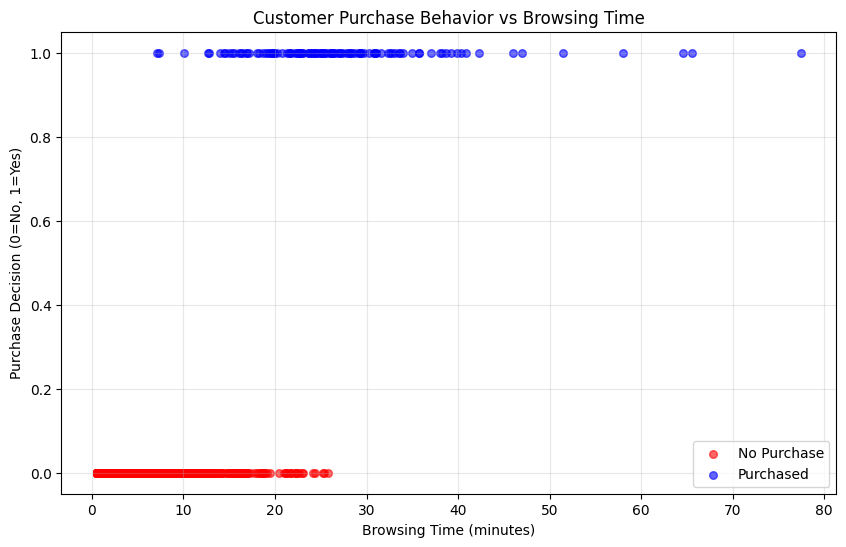

In [13]:
# Create the dataset
print("=== Creating Customer Purchase Dataset ===")
dataset = CustomerDataset(num_samples=800)  # Generate 800 customer samples
print(f"Dataset created with {len(dataset)} customer records")

# Create data loader for batch processing
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)  # Process 32 customers at a time, shuffle for better training

# Visualize the data
def plot_customer_data(dataset):  # Function to visualize customer browsing vs purchase behavior
    """Plot customer browsing time vs purchase decisions"""
    browsing_times = dataset.browsing_time.numpy().flatten()  # Convert to numpy for plotting
    purchases = dataset.purchased.numpy().flatten()  # Convert purchase decisions to numpy
    
    plt.figure(figsize=(10, 6))  # Create figure with specified size
    
    # Plot customers who didn't purchase (red circles)
    no_purchase_mask = purchases == 0  # Boolean mask for non-purchasers
    plt.scatter(browsing_times[no_purchase_mask], purchases[no_purchase_mask], 
               c='red', alpha=0.6, label='No Purchase', s=30)  # Red dots for no purchase
    
    # Plot customers who purchased (blue circles)
    purchase_mask = purchases == 1  # Boolean mask for purchasers
    plt.scatter(browsing_times[purchase_mask], purchases[purchase_mask], 
               c='blue', alpha=0.6, label='Purchased', s=30)  # Blue dots for purchases
    
    plt.xlabel('Browsing Time (minutes)')  # X-axis label
    plt.ylabel('Purchase Decision (0=No, 1=Yes)')  # Y-axis label
    plt.title('Customer Purchase Behavior vs Browsing Time')  # Plot title
    plt.legend()  # Show legend
    plt.grid(True, alpha=0.3)  # Add grid for easier reading
    plt.show()  # Display the plot

plot_customer_data(dataset)  # Visualize the customer data



In [14]:
# =============================================================================
# Define the Neural Network, Criterion Function, Optimizer, and Train the Model
# =============================================================================

print("\n=== Setting Up Neural Network for Purchase Prediction ===")

# Network architecture parameters
input_size = 1    # One input feature: browsing time
hidden_size = 5   # Five neurons in hidden layer (enough to capture non-linear patterns)
output_size = 1   # One output: purchase probability

# Create the neural network model
model = CustomerPurchaseNet(input_size, hidden_size, output_size)  # Instantiate our custom network
print(f"Network Architecture: {input_size} input -> {hidden_size} hidden -> {output_size} output")

# Define loss function for binary classification
criterion = nn.BCELoss()  # Binary Cross Entropy Loss - perfect for binary classification problems

# Define optimizer for updating network weights
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Adam optimizer with learning rate 0.01

# Training parameters
num_epochs = 200  # Number of complete passes through the dataset

print(f"Training for {num_epochs} epochs...")
print("Loss function: Binary Cross Entropy")
print("Optimizer: Adam with learning rate 0.01")

# Train the model
loss_history = train_model(model, train_loader, criterion, optimizer, num_epochs)  # Execute training loop

print("\n=== Training Completed! ===")




=== Setting Up Neural Network for Purchase Prediction ===
Network Architecture: 1 input -> 5 hidden -> 1 output
Training for 200 epochs...
Loss function: Binary Cross Entropy
Optimizer: Adam with learning rate 0.01
Epoch [50/200], Loss: 0.1366
Epoch [100/200], Loss: 0.1348
Epoch [150/200], Loss: 0.1324
Epoch [200/200], Loss: 0.1368

=== Training Completed! ===


Model Accuracy: 0.9463 (94.62%)


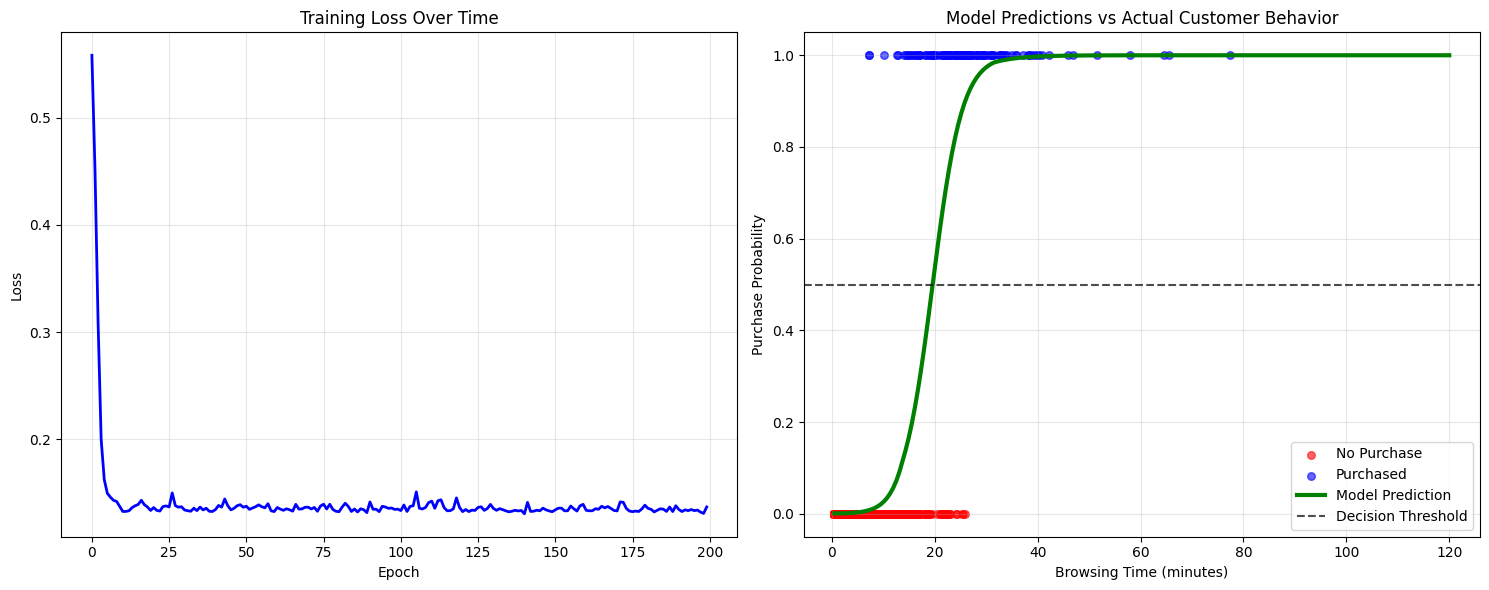

In [15]:
# =============================================================================
# Evaluate and Visualize Results
# =============================================================================

# Evaluate model performance
with torch.no_grad():  # Disable gradient computation for evaluation
    all_predictions = model(dataset.browsing_time)  # Get predictions for all customers
    predicted_purchases = (all_predictions > 0.5).float()  # Convert probabilities to binary predictions
    accuracy = (predicted_purchases == dataset.purchased).float().mean()  # Calculate accuracy

print(f"Model Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Visualize training progress and model predictions
def plot_results(loss_history, dataset, model):  # Function to visualize training results
    """Plot training loss and model predictions"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))  # Create two subplots side by side
    
    # Plot 1: Training loss over time
    ax1.plot(loss_history, 'b-', linewidth=2)  # Blue line showing loss decrease
    ax1.set_xlabel('Epoch')  # X-axis label
    ax1.set_ylabel('Loss')  # Y-axis label
    ax1.set_title('Training Loss Over Time')  # Subplot title
    ax1.grid(True, alpha=0.3)  # Add grid
    
    # Plot 2: Model predictions vs actual data
    browsing_times = dataset.browsing_time.numpy().flatten()  # Get browsing times
    actual_purchases = dataset.purchased.numpy().flatten()  # Get actual purchases
    
    # Generate smooth curve for model predictions
    test_times = torch.linspace(0.5, 120, 200).unsqueeze(1)  # Create range of browsing times
    with torch.no_grad():  # No gradients needed for prediction
        predicted_probs = model(test_times).numpy().flatten()  # Get model predictions across time range
    
    # Plot actual data points
    no_purchase_mask = actual_purchases == 0  # Customers who didn't purchase
    purchase_mask = actual_purchases == 1     # Customers who purchased
    
    ax2.scatter(browsing_times[no_purchase_mask], actual_purchases[no_purchase_mask], 
               c='red', alpha=0.6, label='No Purchase', s=30)  # Red dots for no purchase
    ax2.scatter(browsing_times[purchase_mask], actual_purchases[purchase_mask], 
               c='blue', alpha=0.6, label='Purchased', s=30)  # Blue dots for purchases
    
    # Plot model's predicted probability curve
    ax2.plot(test_times.numpy().flatten(), predicted_probs, 'green', linewidth=3, 
             label='Model Prediction')  # Green curve showing learned decision boundary
    ax2.axhline(y=0.5, color='black', linestyle='--', alpha=0.7, 
                label='Decision Threshold')  # Horizontal line at 50% probability
    
    ax2.set_xlabel('Browsing Time (minutes)')  # X-axis label
    ax2.set_ylabel('Purchase Probability')  # Y-axis label
    ax2.set_title('Model Predictions vs Actual Customer Behavior')  # Subplot title
    ax2.legend()  # Show legend
    ax2.grid(True, alpha=0.3)  # Add grid
    
    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()  # Display the plots

plot_results(loss_history, dataset, model)  # Visualize the complete results



In [16]:
# =============================================================================
# Real-world Application: Making Predictions for New Customers
# =============================================================================

print("\n=== Making Predictions for New Customers ===")

# Simulate new customers with different browsing times
new_customers = torch.tensor([[5.0],    # Customer 1: 5 minutes browsing
                             [15.0],   # Customer 2: 15 minutes browsing  
                             [30.0],   # Customer 3: 30 minutes browsing
                             [60.0]])  # Customer 4: 60 minutes browsing

with torch.no_grad():  # No gradients needed for inference
    purchase_probabilities = model(new_customers)  # Get purchase probabilities

print("New Customer Purchase Predictions:")
for i, (time, prob) in enumerate(zip(new_customers, purchase_probabilities)):  # Loop through predictions
    time_val = time.item()  # Extract browsing time value
    prob_val = prob.item()  # Extract probability value
    prediction = "WILL PURCHASE" if prob_val > 0.5 else "WON'T PURCHASE"  # Make binary decision
    print(f"Customer {i+1}: {time_val:.1f} min browsing -> {prob_val:.3f} probability -> {prediction}")

print(f"\nModel successfully learned to predict customer purchase behavior!")
print(f"This could be used in e-commerce for targeted marketing and inventory planning.")


=== Making Predictions for New Customers ===
New Customer Purchase Predictions:
Customer 1: 5.0 min browsing -> 0.003 probability -> WON'T PURCHASE
Customer 2: 15.0 min browsing -> 0.169 probability -> WON'T PURCHASE
Customer 3: 30.0 min browsing -> 0.974 probability -> WILL PURCHASE
Customer 4: 60.0 min browsing -> 1.000 probability -> WILL PURCHASE

Model successfully learned to predict customer purchase behavior!
This could be used in e-commerce for targeted marketing and inventory planning.
